# Tohoku tsunami inversion
## 2. Comparison of gradients from continuous and discrete approaches on a finer mesh

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock, NonlinearVariationalSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse

_[Define misc plotting functions]_

In [5]:
def plot_mesh(mesh2d, figure=None, axes=None):
    if axes is None:
        figure, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    axes.set_title("Mesh ({:d} elements)".format(mesh2d.num_cells()))
    return axes

In [6]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [7]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

### Forward model

Recall the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0
$$

and initial conditions

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

For this simple implementation we use Taylor-Hood and Crank-Nicolson for for spatial and temporal discretisations, respectively.

This time we choose the next mesh up on the qmesh hierarchy.

In [8]:
level = 1
op = TohokuOptions(level=level)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

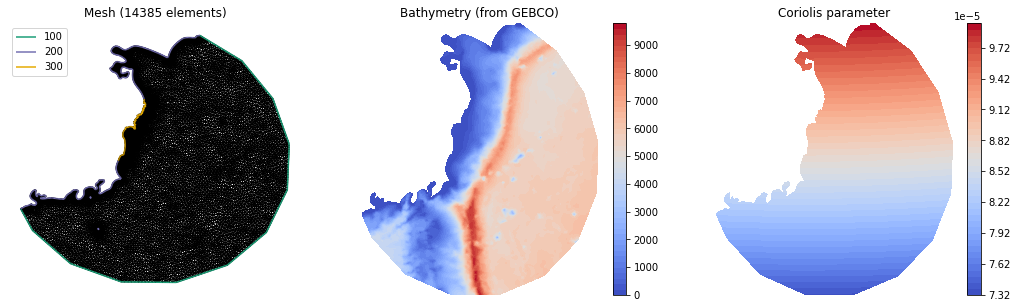

In [9]:
b = Function(P1, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))
plot_fields(mesh, b, f);

In this case we choose $\Gamma_{\mathrm{freeslip}}=\partial\Omega$ and $\Gamma_D=\Gamma_{100}$.

In [10]:
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

In [11]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

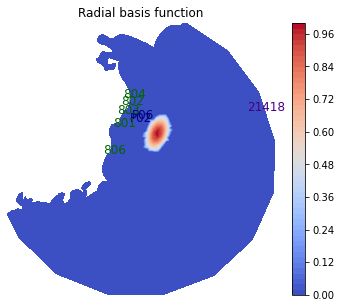

In [12]:
R = FunctionSpace(mesh, "R", 0)
m = Function(R).assign(10.0)

basis_function = Function(TaylorHood)
psi, phi = basis_function.split()

loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
phi.interpolate(gaussian([loc + radii, ], mesh, rotation=angle))
phi.dat.name = "Radial basis function"

q_.project(m*basis_function);

axes = plot_field(phi);
op.annotate_plot(axes, gauges=True)

### Quantity of Interest

Recall the discrete and continuous forms of the QoI:

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\big(\:\eta(\mathbf x_g,t)-\eta_g(t)\:\big)^2\;\mathrm dt.
$$

and

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

respectively.

In [13]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

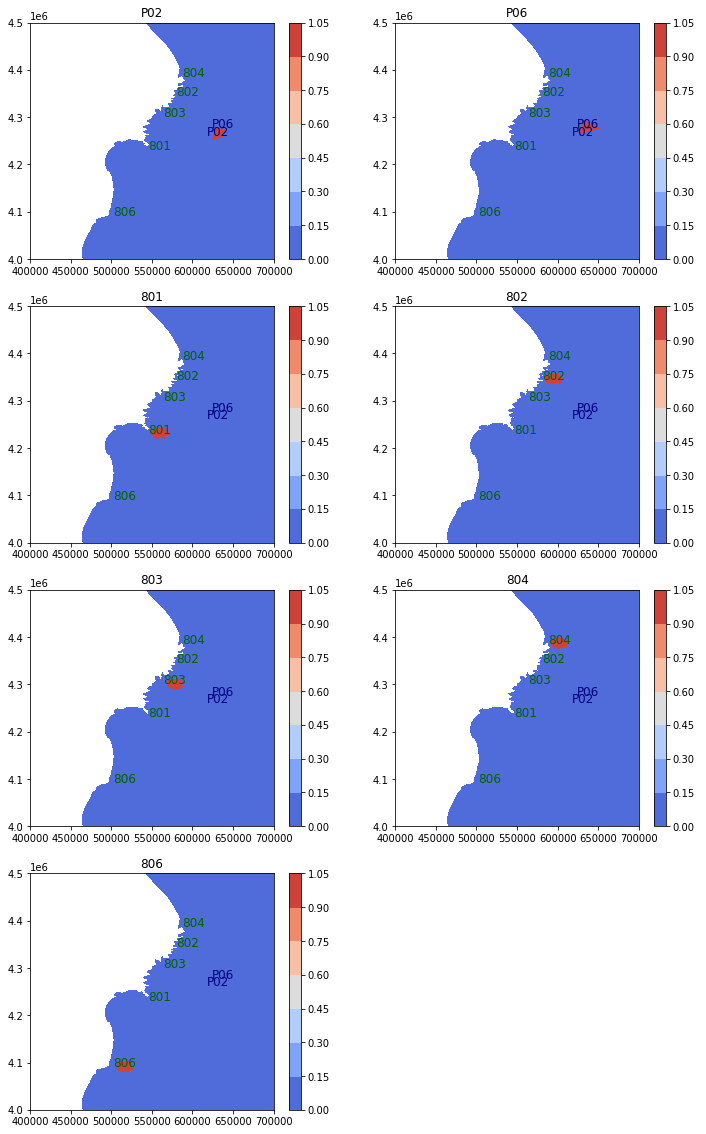

In [14]:
op.gauges.pop('21418')  # This pressure gauge isn't within the domain
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,), ], mesh), P0)
    
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12, 20))
for i, gauge in enumerate(gauges):
    ax = axes[i//2, i%2]
    fig.colorbar(tricontourf(op.gauges[gauge]['indicator'], axes=ax, cmap='coolwarm'), ax=ax);
    ax.set_xlim([0.4e+06, 0.7e+06]);
    ax.set_ylim([4.0e+06, 4.5e+06]);
    ax.set_title(gauge)
    op.annotate_plot(ax, coords='utm', gauges=True)
axes[3, 1].axis(False);

In [15]:
for gauge in gauges:
    op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [16]:
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
for gauge in gauges:
    op.gauges[gauge]['timeseries'] = []
    op.gauges[gauge]['diff'] = []
    op.gauges[gauge]['timeseries_smooth'] = []
    op.gauges[gauge]['diff_smooth'] = []
    op.gauges[gauge]['data'] = []
    op.gauges[gauge]['init'] = None
    op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
times = []

t = 0.0
iteration = 0
J = 0
weight = Constant(1.0)
eta_obs = Constant(0.0)
while t < op.end_time:
    times.append(t)
    if iteration % 48 == 0:
        print("t = {:.1f} minutes".format(t/60))
    
    # Solve forward equation at current timestep
    solver.solve()
    
    # Time integrate QoI
    weight.assign(0.5 if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt else 1.0)
    u, eta = q.split()
    for gauge in op.gauges:
        
        # Point evaluation at gauges
        eta_discrete = eta.at(op.gauges[gauge]["coords"])
        if op.gauges[gauge]['init'] is None:
            op.gauges[gauge]['init'] = eta_discrete
        eta_discrete -= op.gauges[gauge]['init']
        op.gauges[gauge]['timeseries'].append(eta_discrete)
        
        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)
        op.gauges[gauge]['data'].append(obs)
        
        # Discrete form of error
        diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
        op.gauges[gauge]['diff'].append(diff)

        # Continuous form of error
        I = op.gauges[gauge]['indicator']
        A = op.gauges[gauge]['area']
        diff = 0.5*I*(eta - eta_obs)**2
        J += assemble(weight*dtc*diff*dx)
        op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx, annotate=False)/A)
        op.gauges[gauge]['timeseries_smooth'].append(assemble(I*eta_obs*dx, annotate=False)/A)
    
    # Increment
    q_.assign(q)
    t += op.dt
    iteration += 1
    
assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
print("t = {:.1f} minutes".format(t/60))
print("Quantity of interest = {:.4e}".format(J))

t = 0.0 minutes
t = 4.0 minutes
t = 8.0 minutes
t = 12.0 minutes
t = 16.0 minutes
t = 20.0 minutes
t = 24.0 minutes
Quantity of interest = 1.9373e+12


Having run the forward model, we can compare the initial and final solution, as well as the discrete and continuous versions of the timeseries.

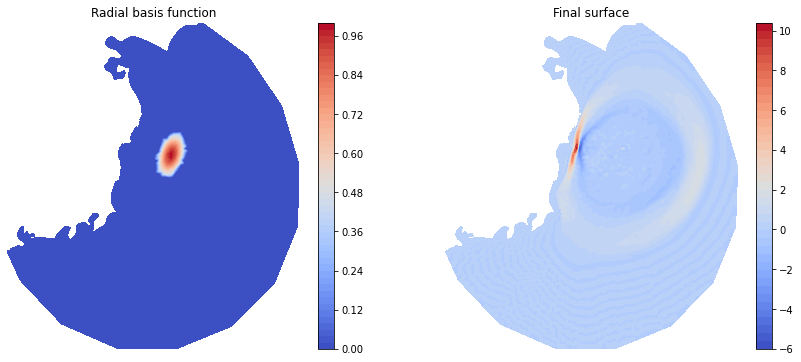

In [17]:
plot_fields(phi, eta, height=6);

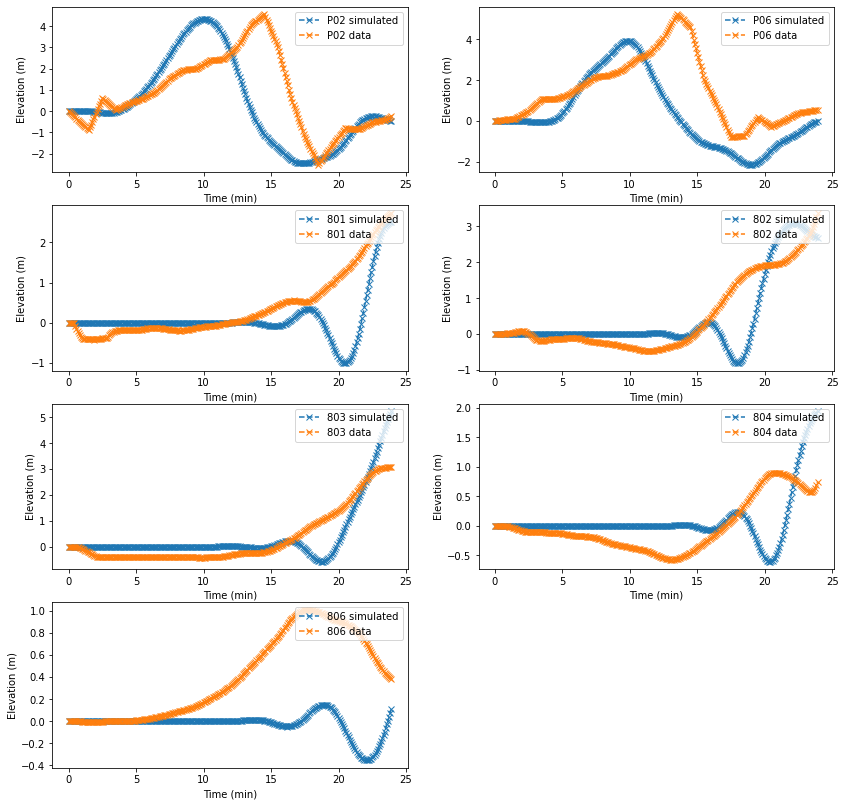

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 2*len(gauges)))

times = np.array(times)
for i, gauge in enumerate(gauges):
    ax = axes[i//2, i%2]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], '--x', label=gauge + ' simulated')
    ax.plot(times/60, op.gauges[gauge]['data'], '--x', label=gauge + ' data')
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[3, 1].axis('off');

Clearly the solution is far from accurate with this very simple initial condition.

Let's compare the continuous and discrete forms of the timeseries error to check that the former provides a good approximation to the latter.

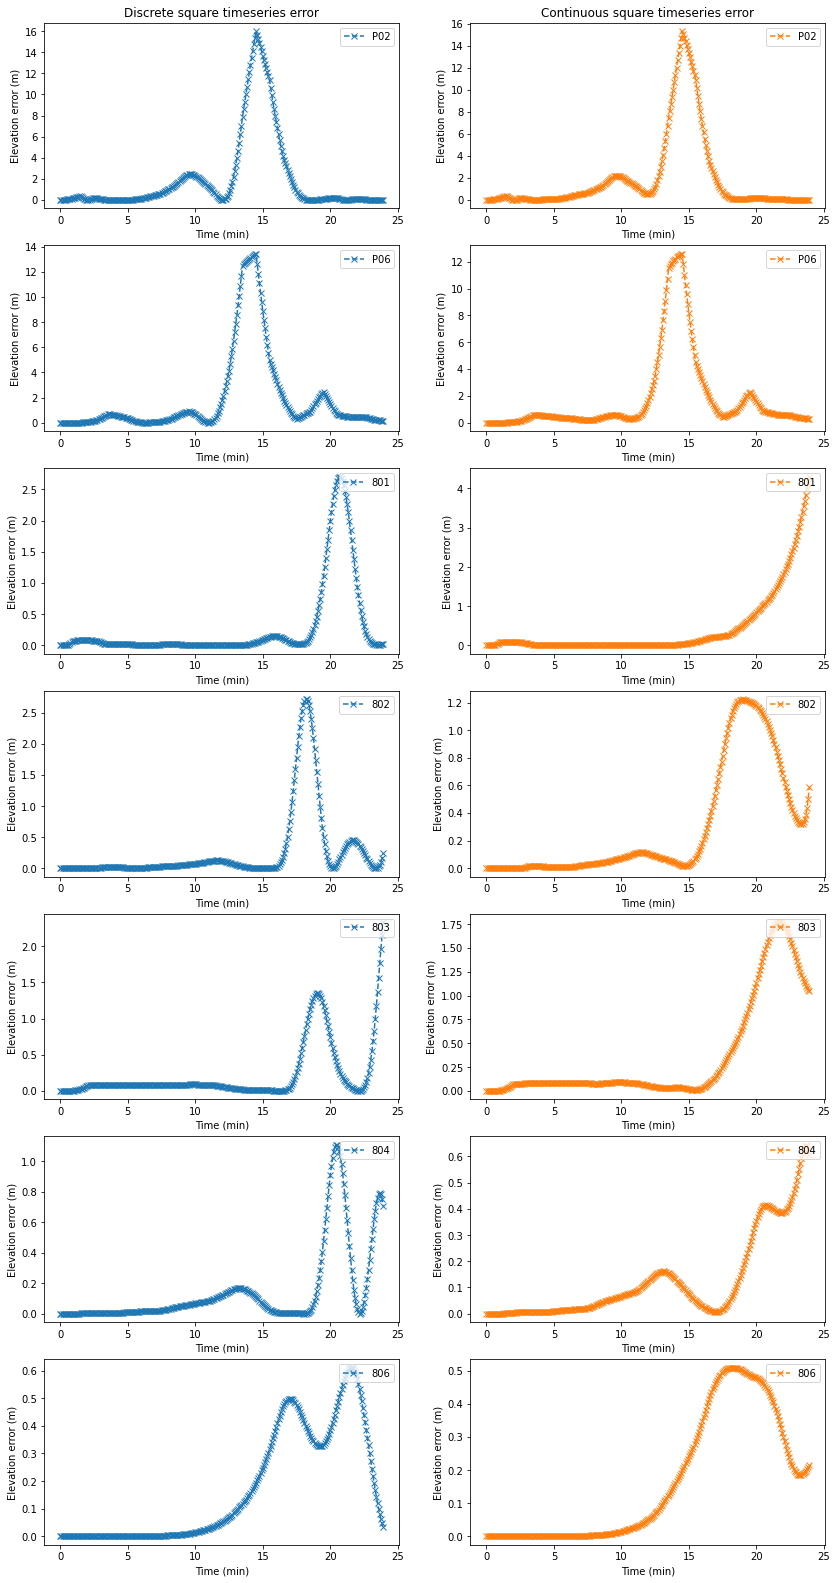

In [19]:
n = len(gauges)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 4*n))

axes[0, 0].set_title("Discrete square timeseries error")
axes[0, 1].set_title("Continuous square timeseries error")
for i, gauge in enumerate(gauges):
    
    N = len(op.gauges[gauge]['diff'])
    axes[i, 0].plot(times/60, op.gauges[gauge]['diff'], '--x', label=gauge)
    axes[i, 0].legend(loc='upper right')
    axes[i, 0].set_xlabel('Time (min)')
    axes[i, 0].set_ylabel('Elevation error (m)')
    
    N = len(op.gauges[gauge]['diff_smooth'])
    axes[i, 1].plot(times/60, op.gauges[gauge]['diff_smooth'], '--x', color='tab:orange', label=gauge)
    axes[i, 1].legend(loc='upper right')
    axes[i, 1].set_xlabel('Time (min)')
    axes[i, 1].set_ylabel('Elevation error (m)')

Compared with the previous notebook, we observe that the continuous form of the error matches the signals in the discrete form for more of the gauges (for example, 802), although there is still some way to go.
The error approximations for P02 and P06 are now particularly well matched.

_[See the sequel of this notebook]_

We can also compare the total variation for each form:

In [20]:
msg = "total variation for gauge {:s}: continuous {:.4e}  discrete {:.4e}"
for gauge in gauges:
    tv_cts = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_dis = total_variation(op.gauges[gauge]['diff'])
    print(msg.format(gauge, tv_cts, tv_dis))

total variation for gauge P02: continuous 3.5418e+01  discrete 3.8766e+01
total variation for gauge P06: continuous 3.0136e+01  discrete 3.4094e+01
total variation for gauge 801: continuous 4.4970e+00  discrete 5.8666e+00
total variation for gauge 802: continuous 2.6316e+00  discrete 6.8523e+00
total variation for gauge 803: continuous 2.6954e+00  discrete 5.2468e+00
total variation for gauge 804: continuous 1.0515e+00  discrete 3.4281e+00
total variation for gauge 806: continuous 8.6547e-01  discrete 1.5305e+00


## Discrete adjoint

During the forward solve, pyadjoint annotated to the tape, meaning we can compute the gradient using its inbuilt automatic differentiation functionality.

In [21]:
g_discrete = compute_gradient(J, Control(m))
print("Gradient computed using discrete adjoint: {:.4e}".format(*g_discrete.dat.data))

Gradient computed using discrete adjoint: 1.7787e+11


In [22]:
stop_annotating();

### Adjoint problem

Recall the adjoint problem, comprised of the adjoint equations

$$
    -\frac{\partial\mathbf u^*}{\partial t}-b\nabla\eta^*-f\widehat{\mathbf z}\times\mathbf u^*=\boldsymbol0,\qquad
    -\frac{\partial\eta^*}{\partial t}-g\nabla\cdot u^*=\sum_{g\in\mathcal G}\mathbb 1_g(\eta-\eta_g),\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

and the final time and boundary conditions

$$
    \mathbf u^*\cdot\widehat{\mathbf n}|_{\partial\Omega\backslash\Gamma_D}\equiv0,\qquad
    \eta^*|_{\partial\Omega\backslash\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \mathbf u^*|_{t=T}\equiv\boldsymbol0,\qquad
    \eta^*|_{t=T}\equiv0.
$$

In [23]:
u_star, eta_star = TrialFunctions(TaylorHood)
q_star_ = Function(TaylorHood)
u_star_, eta_star_ = q_star_.split()

a = -inner(z, u_star)*dx - inner(zeta, eta_star)*dx
L = -inner(z, u_star_)*dx - inner(zeta, eta_star_)*dx

n = FacetNormal(mesh)

def G(uv_star, elev_star):
    F = -b*inner(z, grad(elev_star))*dx
    F += -f*inner(z, as_vector((-uv_star[1], uv_star[0])))*dx
    F += g*inner(grad(zeta), uv_star)*dx
    for tag in boundary_conditions:
        if "dirichlet" in boundary_conditions[tag]:
            F += -inner(zeta*n, uv_star)*ds(tag)
    return F

a += 0.5*dtc*G(u_star, eta_star)
L += -0.5*dtc*G(u_star_, eta_star_)

rhs = Function(P1)

L += zeta*rhs*dx

q_star = Function(TaylorHood)
u_star, eta_star = q_star.split()
u_star.dat.name = "Adjoint velocity"
eta_star.dat.name = "Adjoint surface"

bcs = []
for tag in boundary_conditions:
    if "freeslip" not in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q_star, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

Note that nonlinearity of the QoI manifests iteself as the adjoint RHS depending on the forward model. Dolfin-adjoint has already stored the entire forward trajectory on the tape so there is no need to rerun the forward model and store it.
Usually this is something we'd have to do, of course.

In [24]:
tape = get_working_tape()
solve_blocks = [block for block in tape.get_blocks() if isinstance(block, (SolveVarFormBlock, NonlinearVariationalSolveBlock))]

def get_forward_solution(index):
    return solve_blocks[index].get_outputs()[0].saved_output

In [25]:
assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
num_steps = int(op.end_time/op.dt)
assert iteration == num_steps, print("mismatching step ({:d} vs {:d})".format(iteration, num_steps))
while t > 0.0:
    if iteration % 48 == 0:
        print("t = {:.1f} minutes".format(t/60))
        
    # Evaluate function appearing in RHS
    eta_saved = get_forward_solution(iteration).split()[1]
    expr = 0
    for gauge in gauges:
        expr = expr + op.gauges[gauge]['indicator']*(eta_saved - op.gauges[gauge]['data'][iteration-1]) 
    rhs.interpolate(expr)
    
    # Solve adjoint equation at current timestep
    solver.solve()
    
    # Increment
    q_star_.assign(q_star)
    t -= op.dt
    iteration -= 1
    
assert np.allclose(t, 0.0)
print("t = {:.1f} minutes".format(t/60))

t = 24.0 minutes
t = 20.0 minutes
t = 16.0 minutes
t = 12.0 minutes
t = 8.0 minutes
t = 4.0 minutes
t = 0.0 minutes


Let's compare the continuous and discrete adjoint solutions

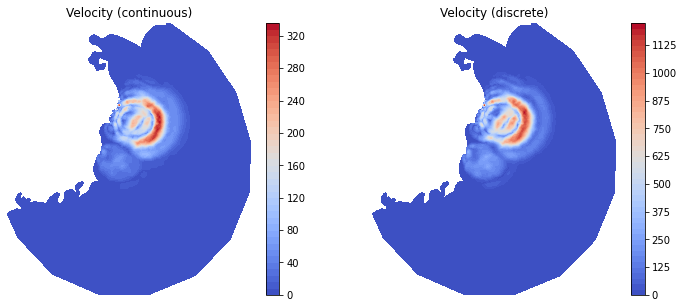

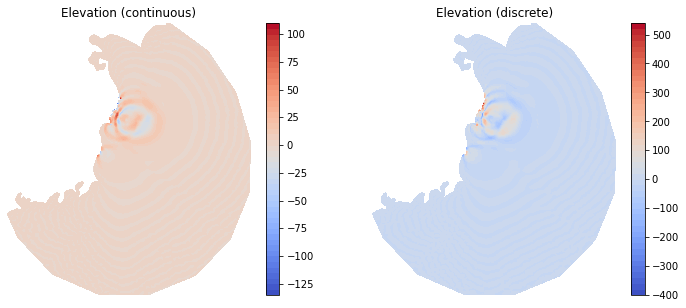

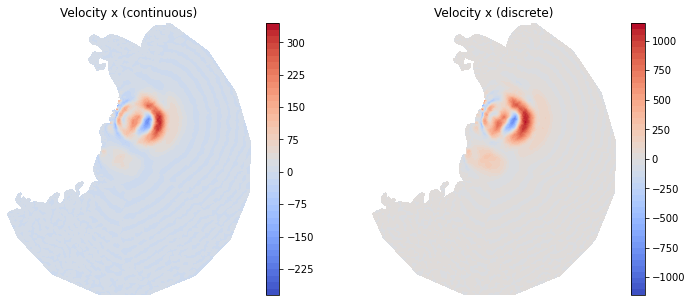

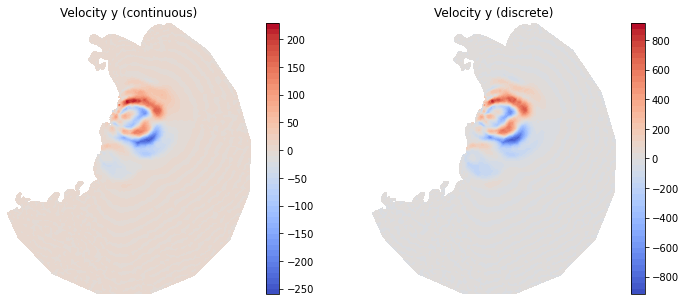

In [26]:
u_star_cts, eta_star_cts = q_star.split()
u_star_dis, eta_star_dis = solve_blocks[0].adj_sol.split()
u_star_cts.dat.name = "Velocity (continuous)"
eta_star_cts.dat.name = "Elevation (continuous)"
u_star_dis.dat.name = "Velocity (discrete)"
eta_star_dis.dat.name = "Elevation (discrete)"
plot_fields(u_star_cts, u_star_dis);
plot_fields(eta_star_cts, eta_star_dis);
for i, comp in enumerate(('Velocity x', 'Velocity y')):
    u_star_cts_comp = Function(P1, name=comp + " (continuous)")
    u_star_dis_comp = Function(P1, name=comp + " (discrete)")
    u_star_cts_comp.interpolate(u_star_cts[i])
    u_star_dis_comp.interpolate(u_star_dis[i])
    plot_fields(u_star_cts_comp, u_star_dis_comp)

The discrete and continuous adjoint solutions look pretty comparable in the eyeball norm except for two important points:
* The elevation has the opposite sign!
* Both elevation and velocity profiles have the different magnitudes.

# [FIXME]

### Gradient computation

Recall that we derived the gradient as

$$
    \frac{\mathrm dJ}{\mathrm dm_k} = \int_\Omega g_k\eta^*|_{t=0}\;\mathrm dx.
$$

In [28]:
g_by_hand_continuous = assemble(phi*q_star.split()[1]*dx)
print("Gradient computed by hand (continuous): {:.4e}".format(g_by_hand_continuous))
print("Relative error in gradient calculation: {:.4f}%".format(100*abs((g_discrete.dat.data[0] - g_by_hand_continuous)/g_discrete.dat.data[0])))

Gradient computed by hand (continuous): -4.2330e+10
Relative error in gradient calculation: 123.7981%


We shouldn't expect agreement because the continuous adjoint solution doesn't look like the discrete adjoint

# [FIXME]